# 2 - Redes neuronales residuales (ResNets)

**Sumario**

1. Redes neuronales residuales (ResNet)
2. Transferencia de aprendizaje

## 2.1 - Redes neuronales residuales (ResNet)

Las redes convolucionales son muy escalables. De este modo, **cuanto mayor sea la cantidad de información que queramos obtener o más compleja, mayor será el número de capas de la sección de extracción** (i.e., capas convolucionales y de pooling) que debemos utilizar, lo que aumentará considerablemente la profundidad de la red y, por tanto, su complejidad. Este aumento de la profundidad puede suponer la aparición del problema del **desvanecimiento del gradiente**.

[Este fenómeno fue observado en 2015 por Kaiming He et al.](https://arxiv.org/pdf/1512.03385.pdf) Incluso después de aplicar *batch normalization*, vieron que una red que usaba más capas funcionaba peor que una red que usaba menos capas, y no había otras diferencias entre los modelos. Lo más interesante es que la diferencia se observó no solo en el conjunto de validación, sino también en el conjunto de entrenamiento; entonces, **no era solo un problema de generalización, sino un problema de entrenamiento**.

<img src="images_2/problema_convolucionales.png" width="600" data-align="center">

Con el objetivo de evitar este problema, se desarrollaron las redes residuales (*Residual Networks*, ResNet por sus siglas en inglés), que constituyen una evolución de las redes convolucionales donde **se incluyen "atajos" o saltos entre las diferentes capas**. Estas nuevas conexiones otorgan flexibilidad de aprendizaje a la red sin añadir casi parámetros. Son interesantes porque le permiten "no utilizar" ciertas capas a menos que sea necesario y le ayudan a reducir el problema del desvanecimiento del gradiente.

<img src="images_2/bloque_residual.png" width="500" data-align="center">

Consideremos que tenemos un bloque residual formado por dos capas convolucionales que devuelve $y = x + \text{bloque}(x)$. Dado que $x$ es la información del bloque anterior, lo que estamos buscando que aprenda la red aqui es la diferencia entre $x$ e $y$. Es decir, si el nuevo bloque aporta información nueva o con la que teníamos en el bloque anterior ya es suficiente. 

Por lo tanto, **una ResNet es buena para aprender sobre las ligeras diferencias entre no hacer nada y pasar a través de un bloque de dos capas convolucionales (con pesos entrenables)**. Así es como estos modelos obtuvieron su nombre: **predicen residuos** (el residuo es valor obtenido de restar la predicción menos el objetivo). A continuación se muestra la estructura de una ResNet profunda que incluye saltos cada dos capas convolucionales (i.e., un "bloque").

<img src="images_2/resnet.png" width="600" data-align="center">

Este tipo de "capa" o bloque no está incluida entra las que ofrece Keras, así que debemos crearlo manualmnte mediante otras capas más básicas. Para ello, incluiremos una serie de modificaciones sobre el modelo convolucional definido en la unidad anterior.

### 2.1.1 - Importación de librerías

In [1]:
from tensorflow import keras
from keras import Input
from keras import Model
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Activation
from keras.layers import Add, BatchNormalization

### 2.1.2 - Definición del bloque residual

Para este ejemplo, vamos a construir un bloque residual similar al que hemos presentado anteriormente. Se le denomina a veces como "bloque residual V1". 

In [2]:
def resnet_block_v1(name, input, filters, kernels = [(3,3), (3,3)]):
    
    # Definición de la primera capa convolucional
    output = Conv2D(
        filters=filters,
        kernel_size=kernels[0],
        strides=(1,1),
        padding="same",
        name=f"resnet_layer_{name}_1"
    )(input) # aplicamos la capa sobre el input
    
    # Definición de la capa de normalización
    output = BatchNormalization(
        axis=3,
        name=f"batch_norm_{name}_1"
    )(output) # aplicamos la capa sobre el input
    
    # Definición de la función de activación de la primera capa convolucional
    output = Activation("relu")(output)
    
    # Definición de la segunda capa convolucional
    output = Conv2D(
        filters=filters,
        kernel_size=kernels[1],
        strides=(1,1),
        padding="same",
        name=f"resnet_layer_{name}_2"
    )(output) # aplicamos la capa sobre el input
    
    # Definición de la capa de normalización
    output = BatchNormalization(
        axis=3,
        name=f"batch_norm_{name}_2"
    )(output) # aplicamos la capa sobre el input
    
    # Definición de la operación de suma entre capa convolucional y la entrada inicial
    output = Add()([output, input])
    
    # Definición de la función de activación final
    output = Activation("relu")(output)
    
    return output

----

**¿Por qué no usamos max-pooling en los bloques residuales?**

Max-pooling es una técnica comúnmente utilizada en las redes convolucionales tradicionales para reducir la dimensionalidad de la imagen con el fin de reducir la complejidad computacional y el sobreajuste. Sin embargo, max-pooling provoca la pérdida de información, ya que solo toma el valor máximo/medio de cada ventana de agrupación y descarta el resto.

<table>
    <tr>
        <th><i>Average-pooling</i></th>
        <th><i>Max-pooling</i></th>
    </tr>
    <tr>
        <td><img src="images_1/average_pooling.png" width="450" data-align="center"></td>
        <td><img src="images_1/max_pooling.png" width="450" data-align="center"></td>
    </tr>
</table>

En ResNets el problema de la complejidad computacional y el sobreajuste se aborda mediante el uso de conexiones de acceso directo, que permiten que la red pase por alto una o más capas, conservando de manera efectiva la dimensionalidad de la imagen. **Esto permite que la red retenga más información y reduce el riesgo de pérdida de información**.

Además, la arquitectura ResNet está diseñada para ser más profunda que las CNN tradicionales, por lo tanto, el uso de max-pooling puede dificultar el mantenimiento de las dimensiones espaciales de los mapas de características. Como resultado, las capas de agrupación máxima normalmente no se incluyen en las arquitecturas de ResNet, ya que no son necesarias para el diseño y la operación de la red.

----

### 2.1.3 - Otro tipos de bloques ResNet

Además de las redes residuales (ResNet) v1 que hemos implementado en este ejemplo, existen otros tipos de bloques definidos para las ResNet:

* **Redes residuales v2**. Se trata de una evolución de la versión inicial donde los procesos de normalización se realizan antes de la ejecución de las capas convolucionales:

<img src="images_2/bloque_residual_v2.png" width="650" data-align="center">

### 2.1.4 - Definición de la red de neuronas

Una vez hemos definido nuestro bloque residual, podemos crear una red con las siguientes características:

* Una capa convolucional con 16 filtros de 3x3 y activación ReLU, junto a max_pooling
* Una capa convolucional con 32 filtros de 3x3 y activación ReLU, junto a max_pooling
* Una serie de 2 bloques residuales v1 con 32 filtros 3x3 cada uno de ellos
* Una capa densa con 512 neuronas y activación ReLU
* Una capa densa con 1 neurona y activación sigmoidal

In [3]:
input_size = 150
num_colors = 3

# Definición de la entrada
input = Input(
    shape=(input_size, input_size, num_colors)
)

# Capa convolucional # 1
output = Conv2D(
    16,
    (3,3)
)(input)
output = Activation("relu")(output)
output = MaxPooling2D(
    (2,2)
)(output)

# Capa convolucional # 2
output = Conv2D(
    32,
    (3,3),
)(output)
output = Activation("relu")(output)
output = MaxPooling2D(
    (2,2)
)(output)

# Bloques residuales
output = resnet_block_v1("1", output, 32)
output = resnet_block_v1("2", output, 32)

# Capa densa
output = Flatten()(output)
output = Dense(
    512,
    activation="relu"
)(output)

# Función de activación final
output = Dense(
    1,
    activation="sigmoid"
)(output)

In [4]:
model = Model(inputs=input, outputs=output, name="ResNet_32")

# Configuración del algoritmo de optimización y de la función de loss
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

# Visualización de la estructura de la red
model.summary()

Model: "ResNet_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 148, 148, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 148, 148, 16  0           ['conv2d[0][0]']                 
                                )                                                         

### 2.1.5 - Entrenamiento con el dataset "cats_and_dogs_filtered"

#### Descarga de datos

In [5]:
import os
os.path.isfile("./cats_and_dogs_filtered.zip")

True

In [6]:
import wget
import os

if os.path.isfile("./cats_and_dogs_filtered.zip") == False:
    url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
    filename = wget.download(url)
else:
    print("Ya se encuentra descargado el archivo en el directorio actual")

Ya se encuentra descargado el archivo en el directorio actual


In [7]:
import  zipfile

local_zip = "./cats_and_dogs_filtered.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

In [8]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


#### Augmentación de datos

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creamos un generador de imágenes con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Generador de datos de aprendizaje en batches de 128
train_generator = train_datagen.flow_from_directory(
    # Definimos el directorio donde se encuentran las imágenes
    "./cats_and_dogs_filtered/train/",
    # Transformamos todas las imágenes a 150x150
    target_size=(150,150),
    # Agrupamos las imágenes en batches de 100
    batch_size=20,
    # Indicamos que las imágenes se mantengan en color (RGB)
    color_mode="rgb",
    # Definimos el problema de clasificación binaria
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [10]:
# Creamos un generador de imagenes que simplemente reescala para los datos de validación
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Generador de datos de validación en batches de 128
val_generator = val_datagen.flow_from_directory(
    # Definimos el directorio donde se encuentran las imágenes
    "./cats_and_dogs_filtered/train/",
    # Transformamos todas las imágenes a 150x150
    target_size=(150,150),
    # Agrupamos las imágenes en batches de 100
    batch_size=20,
    # Indicamos que las imágenes se mantengan en color (RGB)
    color_mode="rgb",
    # Definimos el problema de clasificación binaria
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


#### Entrenamiento de la red

In [11]:
from keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="logs_cats_and_dogs_resnet")

history = model.fit(
    train_generator,
    steps_per_epoch=100,  # 2000 imagenes = batch_size * steps
    epochs=10,
    validation_data=val_generator,
    validation_steps=50,  # 1000 imagenes = batch_size * steps
    verbose=2,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
100/100 - 75s - loss: 0.9998 - accuracy: 0.5310 - val_loss: 0.6919 - val_accuracy: 0.5160 - 75s/epoch - 745ms/step
Epoch 2/10
100/100 - 53s - loss: 0.6751 - accuracy: 0.5855 - val_loss: 0.6893 - val_accuracy: 0.5590 - 53s/epoch - 531ms/step
Epoch 3/10
100/100 - 56s - loss: 0.6614 - accuracy: 0.6075 - val_loss: 0.6721 - val_accuracy: 0.5740 - 56s/epoch - 555ms/step
Epoch 4/10
100/100 - 55s - loss: 0.6504 - accuracy: 0.6345 - val_loss: 0.6438 - val_accuracy: 0.6370 - 55s/epoch - 548ms/step
Epoch 5/10
100/100 - 54s - loss: 0.6309 - accuracy: 0.6495 - val_loss: 0.6313 - val_accuracy: 0.6600 - 54s/epoch - 538ms/step
Epoch 6/10
100/100 - 55s - loss: 0.6269 - accuracy: 0.6425 - val_loss: 0.7444 - val_accuracy: 0.5630 - 55s/epoch - 546ms/step
Epoch 7/10
100/100 - 54s - loss: 0.6151 - accuracy: 0.6555 - val_loss: 1.3050 - val_accuracy: 0.5270 - 54s/epoch - 535ms/step
Epoch 8/10
100/100 - 54s - loss: 0.6024 - accuracy: 0.6645 - val_loss: 1.0544 - val_accuracy: 0.5670 - 54s/epoch - 539

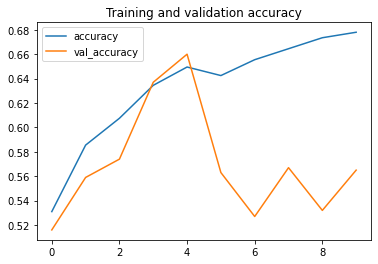

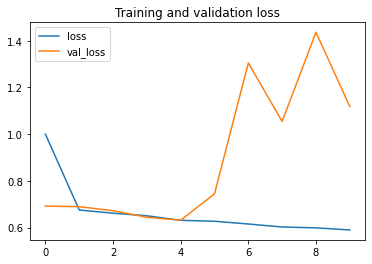

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title("Training and validation accuracy")
plt.legend(["accuracy", "val_accuracy"])

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(["loss", "val_loss"])

Cómo podemos observar tanto en el histórico como en las gráficas, aprende pero no consigue grandes resultados.

Una posible razón de esto es porque el modelo contiene un gran número de parámetros y solo unos pocas instancias (i.e., imágenes) de entrenamiento. Sin embargo, es importante destacar que **cuanto mayor sea la red que queramos aprender desde cero, más cuidadosos deberemos ser con el aprendizaje**. Esto incluye:

* El algoritmo de optimizacion (e.g., Adam, SGD, RMS).
* El *learning rate* de partida (y la estrategia de actualización del *learning rate*).
* El *batch size*.
* El formato de los datos. Por ejemplo, el tamaño de la imagen (150x150, 224x224, etc.).

Además de esto, **hay arquitecturas que pueden funcionar mejor que otras en ciertos datos**. La única forma de saberlo es probando.

La solución más simple a este problema sería por tanto **conseguir más datos**. Sin embargo, **no siempre es posible** (e.g., nuestro dataset es limitado porque conseguir más imágenes es muy caro, como en ciertos problemas de medicina). Por ello, nos puede interesar **utilizar una red pre-aprendida y simplemente ajustarla a nuestro problema particular** aprendiendo solo una parte de los parámetros de la red.


## 2.2 - Transferencia de aprendizaje

El proceso de transferencia de aprendizaje (*transfer learning*) consiste en reutilizar una red aprendida para una determinada tarea con el objeto de resolver otra distinta.

Esta técnica resulta muy útil en tareas de clasificación de imágenes, ya que la extracción de características sobre imágenes es muy similar en todos los casos, de modo que es posible transferir ese aprendizaje a otros procesos que impliquen la extracción de caracteísticas a partir de imágenes.

En lo que se refiere a las redes convolucionales, el proceso de transferencia consiste en reutilizar los parámetros de las capas de la etapa de extracción y simplemente "aprender" la última capa con el objetivo de adaptar la red a la tarea que queremos resolver.

En este caso, [**Keras nos ofrece un amplio conjunto de redes**](https://keras.io/api/applications/) mediante las que aplicar *transfer learning*. En este caso vamos a utilizar una ResNet de 50 capas pre-aprendida siguiendo el siguiente worflow de trabajo:

1. Inicializamos el modelo base (e.g., ResNet50) sin la última capa (i.e., la de clasificación) y cargamos parámetros pre-aprendidos .
2. Congelamos los parámetros de todas las capas del modelo con `trainable=False`.
3. Creamos un nuevo modelo que actuará como la cabeza de la red base.
4. Aprendemos el nuevo modelo con el nuevo dataset.

### 2.2.1 - Importación de librerías

In [13]:
from keras import Input
from keras import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50 # no funciona correctamente
from keras.applications import EfficientNetB0 # no funciona correctamente
from keras.applications import InceptionResNetV2
from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications import VGG16
from keras.applications import MobileNet

----

**Nota:** He probado a modificar el tamaño de la imagen (e.g., con ResNet suele funcionar mejor tamaños de 224x224) pero aún así no he conseguido los resultados que esperaba de ninguna arquitectura residual (i.e., `ResNet50`, `ResNet50V2` y `ResNet101`). También probe a ejecutar la red con una capa densa extra y *fine-tuning*.

Mi intuición me dice que ResNet requiere una estrategia más avanzada de aprendizaje para funcionar correctamente en este problema (e.g., un proceso de actualización del *learning rate*).

Otras arquitecturas convolucionales como **InceptionV3** consiguen un resultado de **90% de accuracy** casi sin esfuerzo. Pero tambien hay otras arquitecturas como **EfficientNet** que no funcionan bien directamente.

----

### 2.2.2 - Creación de la red

Podemos probar diferentes modelos pre-entrenados y construir sobre ellos para nuestro problema particular. En este caso, utilizamos pesos pre-aprendidos del [dataset ImageNet](https://www.image-net.org/challenges/LSVRC/index.php).

In [14]:
input_size = 150
num_colors = 3
input_shape = (input_size, input_size, num_colors)

# Cargamos el modelo pre-entrenado
pre_trained_model = InceptionV3(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False # No queremos incluir la "cabeza" de clasificación de Imagenet de 1000 clases
)

# Congelamos los parámetros del modelo base
pre_trained_model.trainable=False

# Creamos un nuevo modelo sobre él
input = Input(shape=input_shape)

output = pre_trained_model(input, training=False)
# Utilizamos Pooling para pasar de 3*3*2048 valores a 2048 valores
output = GlobalAveragePooling2D()(output)
output = Dense(1, activation="sigmoid")(output)

model = Model(inputs=input, outputs=output, name="transfer_learning_model")

# Configuración del algoritmo de optimización y de la función de loss
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Visualización de la estructura de la red
model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


### 2.2.3 - Entrenamiento

Vamos a entrenar la cabeza de la red durante 2 epochs:

In [15]:
from keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="logs_cats_and_dogs_transfer")

history = model.fit(
    train_generator,
    steps_per_epoch=100,  # 2000 imagenes = batch_size * steps
    epochs=2,
    validation_data=val_generator,
    validation_steps=50,  # 1000 imagenes = batch_size * steps
    verbose=2,
    callbacks=[tensorboard_callback]
)

Epoch 1/2
100/100 - 89s - loss: 0.6977 - accuracy: 0.6710 - val_loss: 0.3987 - val_accuracy: 0.8170 - 89s/epoch - 895ms/step
Epoch 2/2
100/100 - 72s - loss: 0.3762 - accuracy: 0.8265 - val_loss: 0.2452 - val_accuracy: 0.9000 - 72s/epoch - 720ms/step


### 2.2.4 - Mejorando nuestro modelo pre-entrenado

En el caso anterior simplemente hemos intercambiado la capa de clasificación, pero no tenemos porqué quedarnos ahi. Podemos mejorar nuestros resultados de dos maneras posibles:
1. Añadiendo una capa densa entrenable antes de la nueva capa de clasificación. En el caso anterior solo teniamos 2049 parámetros entrenables.
2. Ejecutando un proceso de *fine-tuning* extra con un learning rate inferior para ajustar nuestro modelo pre-entrenado a los datos (no solo la cabeza de clasificación).

----

**Nota:** Si bien ambas opciones pueden mejorar considerablemente la calidad de nuestro modelo, tenemos que tener cuidado porque **pueden llevarnos a problemas de sobreajuste** y que perdamos la "generalización" obtenida de utilizar un modelo pre-entrenado.

----

#### Añadir capa densa entrenable

En este caso, añadimos una capa densa de 512 neuronas con 9 millones de parámetros pueden ser modificados para ajustarse mejor a los datos de entrenamiento.

In [16]:
input_size = 150
num_colors = 3
input_shape = (input_size, input_size, num_colors)

# Cargamos el modelo pre-entrenado
pre_trained_model = InceptionV3(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False # No queremos incluir la "cabeza" de clasificación de Imagenet de 1000 clases
)

# Congelamos los parámetros del modelo base
pre_trained_model.trainable=False

# Creamos un nuevo modelo sobre él
input = Input(shape=input_shape)

output = pre_trained_model(input, training=False)
output = Flatten()(output)
output = Dense(512, activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(1, activation="sigmoid")(output)

model = Model(inputs=input, outputs=output, name="transfer_learning_model_dense")

# Configuración del algoritmo de optimización y de la función de loss
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Visualización de la estructura de la red
model.summary()

Model: "transfer_learning_model_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 31,240,993
Trainable pa

In [17]:
from keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="logs_cats_and_dogs_transfer_dense")

history = model.fit(
    train_generator,
    steps_per_epoch=100,  # 2000 imagenes = batch_size * steps
    epochs=2,
    validation_data=val_generator,
    validation_steps=50,  # 1000 imagenes = batch_size * steps
    verbose=2,
    callbacks=[tensorboard_callback]
)

Epoch 1/2
100/100 - 87s - loss: 0.4918 - accuracy: 0.8880 - val_loss: 0.1349 - val_accuracy: 0.9480 - 87s/epoch - 872ms/step
Epoch 2/2
100/100 - 81s - loss: 0.2106 - accuracy: 0.9255 - val_loss: 0.0869 - val_accuracy: 0.9700 - 81s/epoch - 805ms/step


#### Fine-tuning

El proceso de fine-tuning sería el siguiente:
1. Partimos de un modelo pre-entrenado y cambiamos su cabeza de clasificación.
2. Entrenamos unas pocas iteraciones (e.g., 2-3 epochs) con los pararámetros del modelo congelados excepto los de la nueva cabeza.
3. Descongelamos todo o parte del modelo base y volvemos entrenarlo con un *learning rate* muy bajo.

----

**Nota:** Es muy importante que ejecutemos el paso de *fine-tuning* después de que el modelo haya convergido. Si utilizamos parámetros de la red aprendidos y otros sin aprender, podriamos causar grandes cambios en los gradientes durante el aprendizaje, lo que conllevaria la "destrucción" de información del pre-entrenamiento y por ende la pérdida de calidad del modelo.

Es también fundamental usar un *learning rate* muy bajo en esta etapa, porque se está entrenando un modelo mucho más grande que en la primera ronda de entrenamiento, en un conjunto de datos que suele ser muy pequeño. Como resultado, corremos el riesgo de sobreajustar muy rápidamente si se aplican actualizaciones de pesos muy grandes. Nos interesa actualizar los pesos incrementalmente.

----

##### **Entrenamiento congelado para que converja el modelo**

Hacemos de nuevo lo mismo que en la sección 2.2.2 - 2.2.3. Es decir, partimos de un modelo pre-entrenado congelado y ejecutamos 2 iteraciones. Aqui podemos tener más o menos suerte que la vez anterior, pero el resultado no deberia variar demasiado (y a menos que tengamos mucha suerte, no deberia ser mejor que el modelo con una capa densa o que el modelo después de hacer fine-tuning).

In [18]:
input_size = 150
num_colors = 3
input_shape = (input_size, input_size, num_colors)

# Cargamos el modelo pre-entrenado
pre_trained_model = InceptionV3(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False # No queremos incluir la "cabeza" de clasificación de Imagenet de 1000 clases
)

# Congelamos los parámetros del modelo base
pre_trained_model.trainable=False

# Creamos un nuevo modelo sobre él
input = Input(shape=input_shape)

output = pre_trained_model(input, training=False)
output = GlobalAveragePooling2D()(output) # Utilizamos Pooling para pasar de 3*3*2048 valores a 2048 valores
output = Dense(1, activation="sigmoid")(output)

model = Model(inputs=input, outputs=output, name="transfer_learning_model_finetuned")

# Configuración del algoritmo de optimización y de la función de loss
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Visualización de la estructura de la red
model.summary()

Model: "transfer_learning_model_finetuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [19]:
from keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="logs_cats_and_dogs_transfer_finetuned")

history = model.fit(
    train_generator,
    steps_per_epoch=100,  # 2000 imagenes = batch_size * steps
    epochs=2,
    validation_data=val_generator,
    validation_steps=50,  # 1000 imagenes = batch_size * steps
    verbose=2,
    callbacks=[tensorboard_callback]
)

Epoch 1/2
100/100 - 77s - loss: 0.4753 - accuracy: 0.7815 - val_loss: 0.2660 - val_accuracy: 0.8920 - 77s/epoch - 774ms/step
Epoch 2/2
100/100 - 69s - loss: 0.2950 - accuracy: 0.8685 - val_loss: 0.1913 - val_accuracy: 0.9290 - 69s/epoch - 690ms/step


##### **Descongelamos el modelo y entrenamos con un *learning rate* muy bajo**

In [20]:
# Descongelamos el modelo
pre_trained_model.trainable=True

# Configuración del algoritmo de optimización y de la función de loss
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-5), # menor learning rate, 1e-5 vs 1e-4
              metrics=['accuracy'])

# Entrenamos por 2 epochs más
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # 2000 imagenes = batch_size * steps
    epochs=2, 
    validation_data=val_generator,
    validation_steps=50,  # 1000 imagenes = batch_size * steps
    verbose=2,
    callbacks=[tensorboard_callback]
)

Epoch 1/2
100/100 - 286s - loss: 0.1802 - accuracy: 0.9285 - val_loss: 0.0602 - val_accuracy: 0.9820 - 286s/epoch - 3s/step
Epoch 2/2
100/100 - 255s - loss: 0.1071 - accuracy: 0.9600 - val_loss: 0.0414 - val_accuracy: 0.9900 - 255s/epoch - 3s/step


<span style="color:blue"><b>El modelo de fine-tuning obtiene mejores resultados, pero tarda más en completarse</b></span>